In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test") \
     .getOrCreate()

In [2]:
import urllib.request  # lib that handles URLs
import io
import pandas as pd
pd.options.display.max_rows=250
import numpy as np
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

import pyspark.sql.functions as func

In [3]:
df_events = spark.read.parquet("s3://bigdataproject-pr/filtered_events.parquet")
df_events.cache()

DataFrame[GlobalEventID: int, SQLDATE: int, MonthYear: int, Actor1Name: string, Actor2Name: string, EventCode: string, GoldsteinScale: double, NumMentions: int, NumSources: int, NumArticles: int, AvgTone: double, ActionGeo_CountryCode: string, ActionGeo_Fullname: string, ActionGeo_FeatureID: string, SOURCEURL: string, ActionGeo_Lat: double, ActionGeo_Long: string]

In [35]:
df_events.where(df_events.Actor1Name == 'DONALD TRUMP').show(5)

+-------------+-------+---------+----------+----------+---------+--------------+-----------+----------+-----------+-------+---------------------+------------------+-------------------+---------+-------------+--------------+
|GlobalEventID|SQLDATE|MonthYear|Actor1Name|Actor2Name|EventCode|GoldsteinScale|NumMentions|NumSources|NumArticles|AvgTone|ActionGeo_CountryCode|ActionGeo_Fullname|ActionGeo_FeatureID|SOURCEURL|ActionGeo_Lat|ActionGeo_Long|
+-------------+-------+---------+----------+----------+---------+--------------+-----------+----------+-----------+-------+---------------------+------------------+-------------------+---------+-------------+--------------+
+-------------+-------+---------+----------+----------+---------+--------------+-----------+----------+-----------+-------+---------------------+------------------+-------------------+---------+-------------+--------------+



In [4]:
#find urls that include Trump news
#did not use Actor1Name and Actor2Name to filter for Trump due to the number of null values included in both columns
relevant_events = df_events.where(df_events.SOURCEURL.rlike('trump'))


In [5]:
import pandas as pd
relevant_events1 = relevant_events.toPandas()
relevant_events1["MonthYear"] = pd.to_datetime(relevant_events1["MonthYear"], format='%Y%m')
relevant_events1["Year"] = relevant_events1.MonthYear.dt.year


/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [31]:
#find event with most mentions of Trump
relevant_events1.loc[relevant_events1.NumMentions.max()]

#using the GDELT CAMEO code guide, we see that EventCode 036 means "Express Intent to meet or negotiate"

GlobalEventID                                                    621130008
SQLDATE                                                           20170127
MonthYear                                              2017-01-01 00:00:00
Actor1Name                                                       PRESIDENT
Actor2Name                                                     THERESA MAY
EventCode                                                              036
GoldsteinScale                                                           4
NumMentions                                                              8
NumSources                                                               1
NumArticles                                                              4
AvgTone                                                            1.35849
ActionGeo_CountryCode                                                   UK
ActionGeo_Fullname                                          United Kingdom
ActionGeo_FeatureID      

In [32]:
relevant_events1.loc[relevant_events1.NumArticles.max()]

#the Trump-related event with the most articles, as we can see involves the immigrant crisis
#EventCode 173 means "Arrest, detain, or charge with legal action"

GlobalEventID                                                    621129063
SQLDATE                                                           20170127
MonthYear                                              2017-01-01 00:00:00
Actor1Name                                                         MIGRANT
Actor2Name                                                            None
EventCode                                                              173
GoldsteinScale                                                          -5
NumMentions                                                              5
NumSources                                                               1
NumArticles                                                              5
AvgTone                                                           -3.75114
ActionGeo_CountryCode                                                   MX
ActionGeo_Fullname                           Guadalupe, Nuevo LeóX, Mexico
ActionGeo_FeatureID      

In [6]:
relevant_events1 = relevant_events1[relevant_events1["Year"] >= 2017]

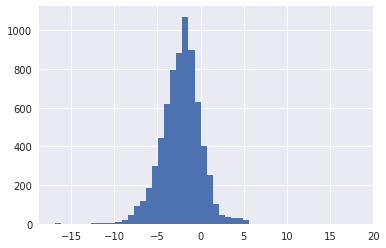

In [31]:
#look for Trump-related events that have Putin as an Actor; evaluate AvgTone surrounding this data
putin_df = relevant_events1.loc[relevant_events1['Actor2Name'] == 'VLADIMIR PUTIN']
putin_df.AvgTone.hist(bins = 50)

In [32]:
putin_df.AvgTone.mean()

-2.2536423480343037

In [24]:
relevant_events1.where(relevant_events1.Year == 2017).count()

GlobalEventID            2720613
SQLDATE                  2720613
MonthYear                2720613
Actor1Name               2575246
Actor2Name               2224950
EventCode                2720613
GoldsteinScale           2720606
NumMentions              2720613
NumSources               2720613
NumArticles              2720613
AvgTone                  2720613
ActionGeo_CountryCode    2711899
ActionGeo_Fullname       2711529
ActionGeo_FeatureID      2711899
SOURCEURL                2720613
ActionGeo_Lat            2711528
ActionGeo_Long           2711673
Year                     2720613
dtype: int64

In [25]:
relevant_events1.where(relevant_events1.Year == 2018).count()

GlobalEventID            1532914
SQLDATE                  1532914
MonthYear                1532914
Actor1Name               1446865
Actor2Name               1255462
EventCode                1532914
GoldsteinScale           1532908
NumMentions              1532914
NumSources               1532914
NumArticles              1532914
AvgTone                  1532914
ActionGeo_CountryCode    1527852
ActionGeo_Fullname       1527636
ActionGeo_FeatureID      1527852
SOURCEURL                1532914
ActionGeo_Lat            1527636
ActionGeo_Long           1527658
Year                     1532914
dtype: int64

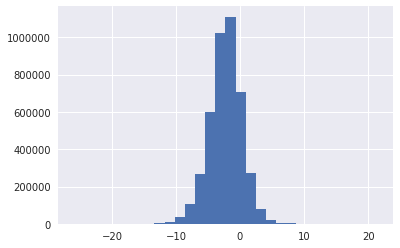

In [21]:
#view distribution of AvgTone
relevant_events1['AvgTone'].hist(bins = 30)

In [16]:
#find correlation of selected features
relevant_events1.corr()

,GlobalEventID,SQLDATE,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,ActionGeo_Lat,Year
GlobalEventID,1.000000,0.896800,0.028109,0.001102,0.015386,0.000481,-0.019228,0.006650,0.865851
SQLDATE,0.896800,1.000000,0.027987,0.001135,0.011492,0.000570,0.000307,0.012075,0.997700
GoldsteinScale,0.028109,0.027987,1.000000,-0.006487,0.005273,-0.006615,0.202601,0.004930,0.027704
NumMentions,0.001102,0.001135,-0.006487,1.000000,0.652623,0.989976,-0.005891,-0.001270,0.001012
NumSources,0.015386,0.011492,0.005273,0.652623,1.000000,0.659922,0.001253,0.007999,0.010677
NumArticles,0.000481,0.000570,-0.006615,0.989976,0.659922,1.000000,-0.006552,-0.001632,0.000471
AvgTone,-0.019228,0.000307,0.202601,-0.005891,0.001253,-0.006552,1.000000,-0.001808,0.003680
ActionGeo_Lat,0.006650,0.012075,0.004930,-0.001270,0.007999,-0.001632,-0.001808,1.000000,0.012827
Year,0.865851,0.997700,0.027704,0.001012,0.010677,0.000471,0.003680,0.012827,1.000000


In [22]:
df = relevant_events1[["NumMentions", "ActionGeo_CountryCode", "AvgTone", "Year"]]

In [23]:
df1 = relevant_events1.groupby(["ActionGeo_CountryCode", "Year"]).agg({"NumMentions": "count", "AvgTone": "mean"}).unstack()

In [24]:
df1 = df1.sort_values([("NumMentions", 2017),("NumMentions", 2018)], ascending = False)

In [25]:
top_10 = df1[:10]

In [26]:
top_10 = top_10.drop("NumMentions", axis=1)
top_10 = top_10["AvgTone"]

In [9]:
pip install pandas-bokeh

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [29]:
top_10.plot_bokeh.bar(
    ylabel="AvgTone", 
    title="Sentiment for Top 10 Countries by Trump Mentions", 
    alpha=0.6)

Figure(id='1191', ...)

In [6]:
relevant_events1["ActionGeo_Lat"] = pd.to_numeric(relevant_events1["ActionGeo_Lat"], errors = 'coerce')
relevant_events1["ActionGeo_Long"] = pd.to_numeric(relevant_events1["ActionGeo_Long"], errors = 'coerce')

In [8]:
df_mapplot = relevant_events1[["NumMentions", "ActionGeo_Lat", "ActionGeo_Long", "ActionGeo_CountryCode", "ActionGeo_Fullname"]]
df_mapplot = df_mapplot.dropna(subset=["ActionGeo_Lat", "ActionGeo_Long"])


In [9]:
pip install geopandas

     |████████████████████████████████| 901kB 34.2MB/s 
     |████████████████████████████████| 1.5MB 39.3MB/s 
     |████████████████████████████████| 11.2MB 40.8MB/s 
     |████████████████████████████████| 17.9MB 39.7MB/s 
  Stored in directory: /home/hadoop/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
Note: you may need to restart the kernel to use updated packages.


In [10]:
import geopandas
from shapely.geometry import Point
df_mapplot['coordinates'] = df_mapplot[['ActionGeo_Long', 'ActionGeo_Lat']].values.tolist()
df_mapplot['coordinates'] = df_mapplot['coordinates'].apply(Point)

In [11]:
df_mapplot = geopandas.GeoDataFrame(df_mapplot, geometry ='coordinates')
df_mapplot = df_mapplot.rename(columns = {"coordinates": "geometry"})

In [28]:
df_mapplot = df_mapplot.set_geometry('geometry')x


In [31]:
pip install mapclassify

  Stored in directory: /home/hadoop/.cache/pip/wheels/fc/b8/58/56b650743289cbecb476ef1fc50ab0aeaa0b12e56ad912d624
  Stored in directory: /home/hadoop/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Successfully built mapclassify wrapt
Note: you may need to restart the kernel to use updated packages.


/home/hadoop/miniconda/lib/python3.6/site-packages/mapclassify/classifiers.py:138: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/hadoop/miniconda/lib/python3.6/site-packages/mapclassify/classifiers.py:140: UserWarning: Warning: setting k to 7
  Warn("Warning: setting k to %d" % k_q, UserWarning)


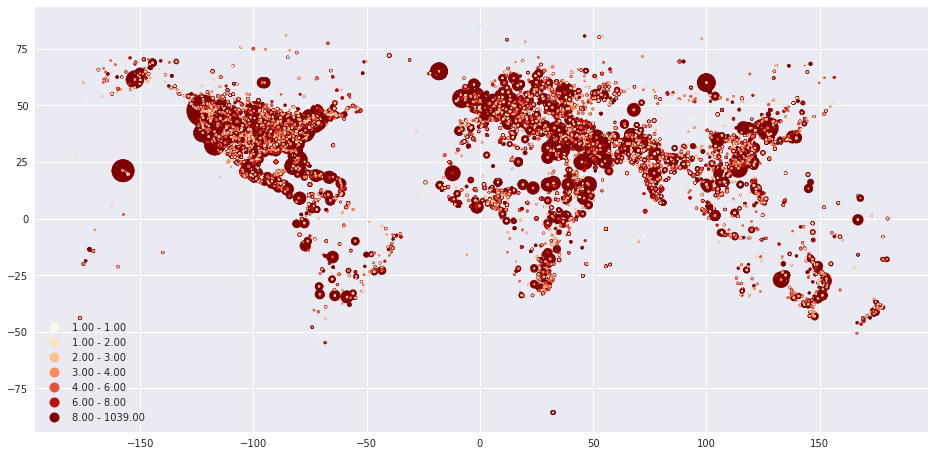

In [36]:
import mapclassify
df_mapplot.plot(column = "NumMentions", cmap = 'OrRd', markersize = df_mapplot['NumMentions'], scheme='quantiles', k = 9, figsize =(16, 19), legend =True);

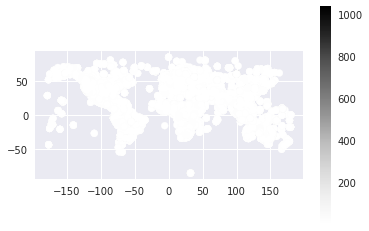

In [34]:
fig, ax = plt.subplots(1,1)

df_mapplot.plot(column= 'NumMentions', ax=ax, legend=True)

In [6]:
spark.stop()